<a href="https://colab.research.google.com/github/nourbenmoulehem/AUTOMATCH/blob/main/AUTOMATCH%20BO2%3A%20random%20forest%20%2B%20SVM%20%2B%20XGBoost%20for%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# ================================
# 1. CONFIGURATION & IMPORTS
# ================================
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve,  ConfusionMatrixDisplay
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV



In [4]:
# ================================
# 2. CHARGEMENT DES DONNÉES
# ================================
df = pd.read_csv('vehicle_maintenance_data.csv')

print(f"Shape : {df.shape}")
display(df.head())

Shape : (50000, 20)


,Vehicle_Model,Mileage,Maintenance_History,Reported_Issues,Vehicle_Age,Fuel_Type,Transmission_Type,Engine_Size,Odometer_Reading,Last_Service_Date,Warranty_Expiry_Date,Owner_Type,Insurance_Premium,Service_History,Accident_History,Fuel_Efficiency,Tire_Condition,Brake_Condition,Battery_Status,Need_Maintenance
0,Truck,58765,Good,0,4,Electric,Automatic,2000,28524,2023-11-23,2025-06-24,Second,20782,6,3,13.622204,New,New,Weak,1
1,Van,60353,Average,1,7,Electric,Automatic,2500,133630,2023-09-21,2025-06-04,Second,23489,7,0,13.625307,New,New,Weak,1
2,Bus,68072,Poor,0,2,Electric,Automatic,1500,34022,2023-06-27,2025-04-27,First,17979,7,0,14.306302,New,Good,Weak,1
3,Bus,60849,Average,4,5,Petrol,Automatic,2500,81636,2023-08-24,2025-11-05,Second,6220,7,3,18.709467,New,Worn Out,New,1
4,Bus,45742,Poor,5,1,Petrol,Manual,2000,97162,2023-05-25,2025-09-14,Third,16446,6,2,16.977482,Good,Good,Weak,1


In [5]:
numerical_cols = [
    'Mileage',
    'Vehicle_Age',
    'Reported_Issues',
    'Fuel_Efficiency',
    'Service_History',
    'Accident_History'
]

categorical_cols = [
    'Maintenance_History',
    'Tire_Condition',
    'Brake_Condition',
    'Battery_Status'
]

print(f"\n Variables numériques ({len(numerical_cols)}) :")
for col in numerical_cols:
    print(f"   - {col}")

print(f"\n Variables catégorielles ({len(categorical_cols)}) :")
for col in categorical_cols:
    print(f"   - {col}")



 Variables numériques (6) :
   - Mileage
   - Vehicle_Age
   - Reported_Issues
   - Fuel_Efficiency
   - Service_History
   - Accident_History

 Variables catégorielles (4) :
   - Maintenance_History
   - Tire_Condition
   - Brake_Condition
   - Battery_Status



Distribution de Need_Maintenance :
Need_Maintenance
1    0.80996
0    0.19004
Name: proportion, dtype: float64


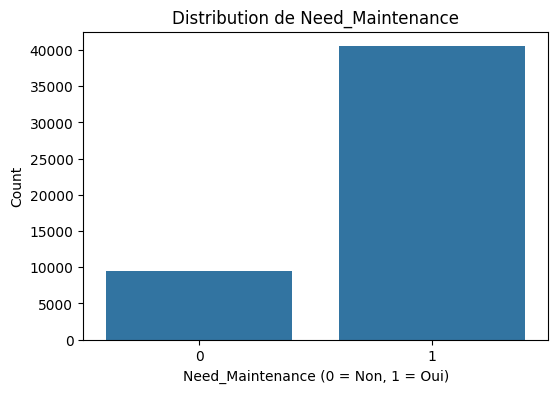

In [6]:
# 1. Distribution de la variable cible
print("\nDistribution de Need_Maintenance :")
print(df['Need_Maintenance'].value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.countplot(x='Need_Maintenance', data=df)
plt.title('Distribution de Need_Maintenance')
plt.xlabel('Need_Maintenance (0 = Non, 1 = Oui)')
plt.ylabel('Count')
plt.show()

Cela indique un déséquilibre des classes : environ 81 % des véhicules nécessitent une maintenance (1), tandis que seulement 19 % n'en nécessitent pas (0). Ce déséquilibre pourrait affecter les performances des modèles, car ils peuvent être biaisés vers la classe majoritaire.
 Ce bloc effectue une exploration initiale des données en affichant la distribution de la variable cible (Need_Maintenance) et évalue plusieurs modèles d'apprentissage automatique en les entraînant, en effectuant des prédictions et en visualisant leurs performances à travers la précision, les rapports de classification et les matrices de confusion.

In [7]:
print(f'\nDataset Shape: {df.shape[0]} rows × {df.shape[1]} columns')
print(f'Total data points (cells): {df.shape[0] * df.shape[1]:,}')

# Premières lignes
print('\n--- First 5 Rows ---')
print(df.head())

# Dernières lignes
print('\n--- Last 5 Rows ---')
print(df.tail())

# Échantillon aléatoire
print('\n--- Random Sample (5 rows) ---')
print(df.sample(5, random_state=42))


Dataset Shape: 50000 rows × 20 columns
Total data points (cells): 1,000,000

--- First 5 Rows ---
  Vehicle_Model  Mileage Maintenance_History  Reported_Issues  Vehicle_Age  \
0         Truck    58765                Good                0            4   
1           Van    60353             Average                1            7   
2           Bus    68072                Poor                0            2   
3           Bus    60849             Average                4            5   
4           Bus    45742                Poor                5            1   

  Fuel_Type Transmission_Type  Engine_Size  Odometer_Reading  \
0  Electric         Automatic         2000             28524   
1  Electric         Automatic         2500            133630   
2  Electric         Automatic         1500             34022   
3    Petrol         Automatic         2500             81636   
4    Petrol            Manual         2000             97162   

  Last_Service_Date Warranty_Expiry_Date Owner_

In [8]:
#2. Définir les features numériques et catégoriques
numerical_cols = ['Mileage', 'Vehicle_Age', 'Reported_Issues', 'Fuel_Efficiency',
                  'Service_History', 'Accident_History']
categorical_cols = ['Maintenance_History', 'Tire_Condition', 'Brake_Condition', 'Battery_Status']

- Variables numériques : Normalisation/standardisation nécessaire
- Variables catégorielles : Encodage requis (One-Hot ou Label Encoding)
- Maintenance_History pourrait être traitée comme ordinale

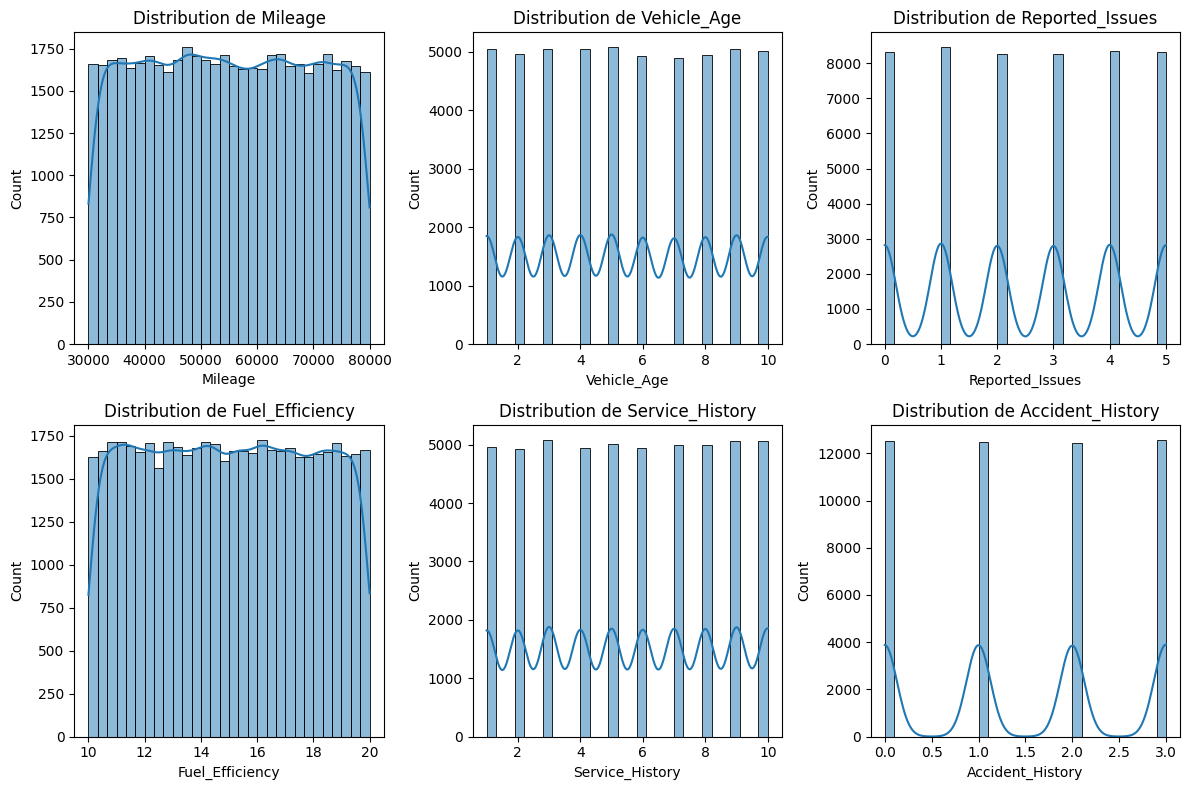

In [9]:
# 3. Distribution des features numériques
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution de {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

Lecture du graphique :
- Entre 30k-32k km → environ 1,650 voitures
- Entre 40k-42k km → environ 1,700 voitures  
- Entre 50k-52k km → environ 1,680 voitures
- Entre 60k-62k km → environ 1,690 voitures
- Entre 70k-72k km → environ 1,660 voitures


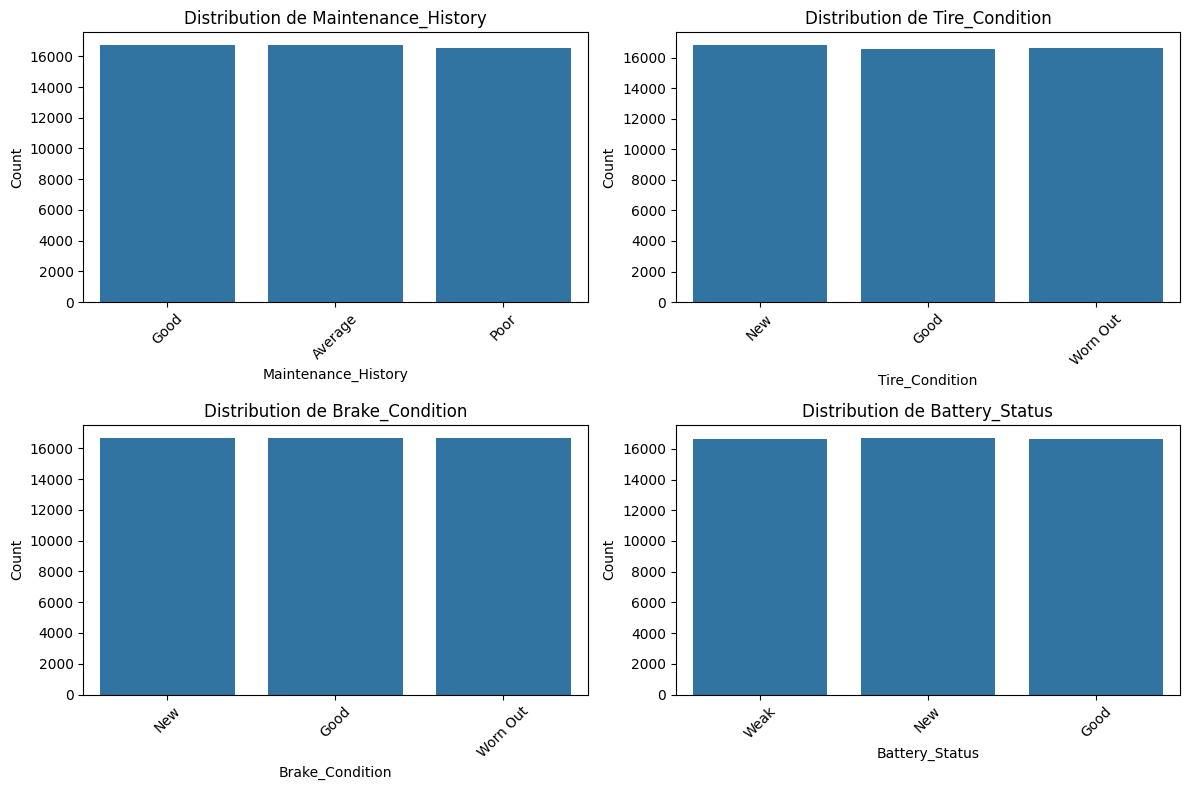

In [10]:
# 4. Distribution des features catégoriques
plt.figure(figsize=(12, 8))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution de {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

16,000 voitures ont un **bon** historique d'entretien
- 16,000 voitures ont un historique d'entretien **moyen**
- 16,000 voitures ont un **mauvais** historique d'entretien
New       :16,000 voitures avec pneus neufs
Good      :  16,000 voitures avec pneus en bon état
Worn Out  : 16,000 voitures avec pneus usés
### **Brake_Condition (État des freins)**
```
New       :  16,000 voitures avec freins neufs
Good      :  16,000 voitures avec freins en bon état
Worn Out  : 16,000 voitures avec freins usés
```
### **Battery_Status (État de la batterie)**
```
Weak : 16,000 voitures avec batterie faible
New  :  16,000 voitures avec batterie neuve
Good :  16,000 voitures avec batterie en bon état

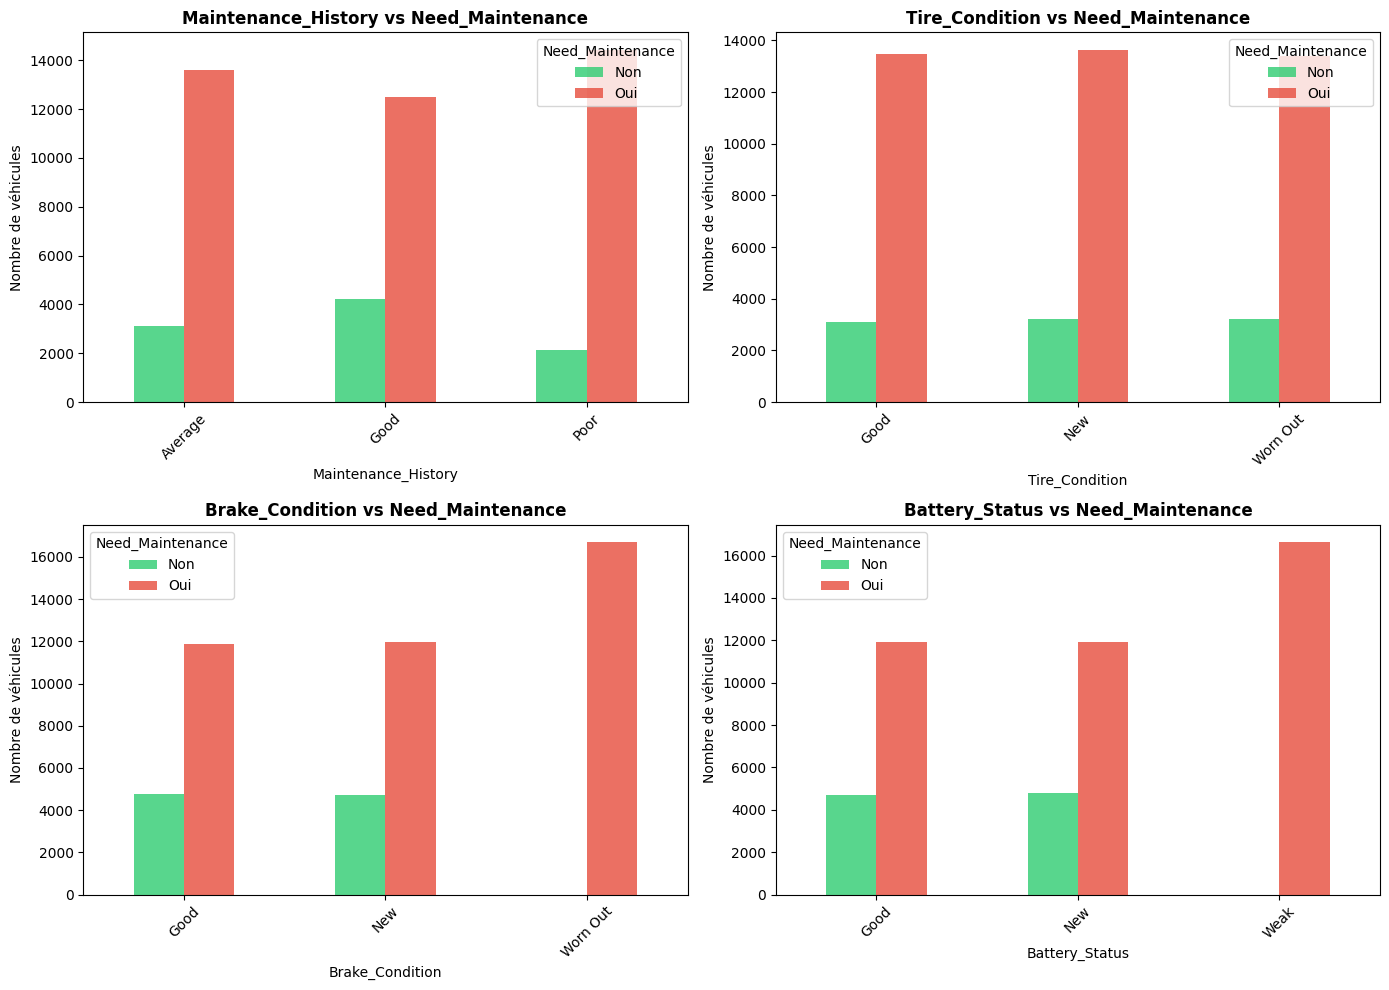

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    df_count = df.groupby([col, 'Need_Maintenance']).size().unstack(fill_value=0)
    df_count.plot(kind='bar', ax=axes[i], color=['#2ecc71', '#e74c3c'], alpha=0.8)
    axes[i].set_title(f'{col} vs Need_Maintenance', fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Nombre de véhicules')
    axes[i].legend(['Non', 'Oui'], title='Need_Maintenance')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [12]:
# Vérification des valeurs manquantes
print("\nValeurs manquantes :")
print(df.isnull().sum())

# Vérification des outliers (par IQR pour les features numériques)
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)][col]
    print(f"\nOutliers dans {col} : {len(outliers)}")


Valeurs manquantes :
Vehicle_Model           0
Mileage                 0
Maintenance_History     0
Reported_Issues         0
Vehicle_Age             0
Fuel_Type               0
Transmission_Type       0
Engine_Size             0
Odometer_Reading        0
Last_Service_Date       0
Warranty_Expiry_Date    0
Owner_Type              0
Insurance_Premium       0
Service_History         0
Accident_History        0
Fuel_Efficiency         0
Tire_Condition          0
Brake_Condition         0
Battery_Status          0
Need_Maintenance        0
dtype: int64

Outliers dans Mileage : 0

Outliers dans Vehicle_Age : 0

Outliers dans Reported_Issues : 0

Outliers dans Fuel_Efficiency : 0

Outliers dans Service_History : 0

Outliers dans Accident_History : 0


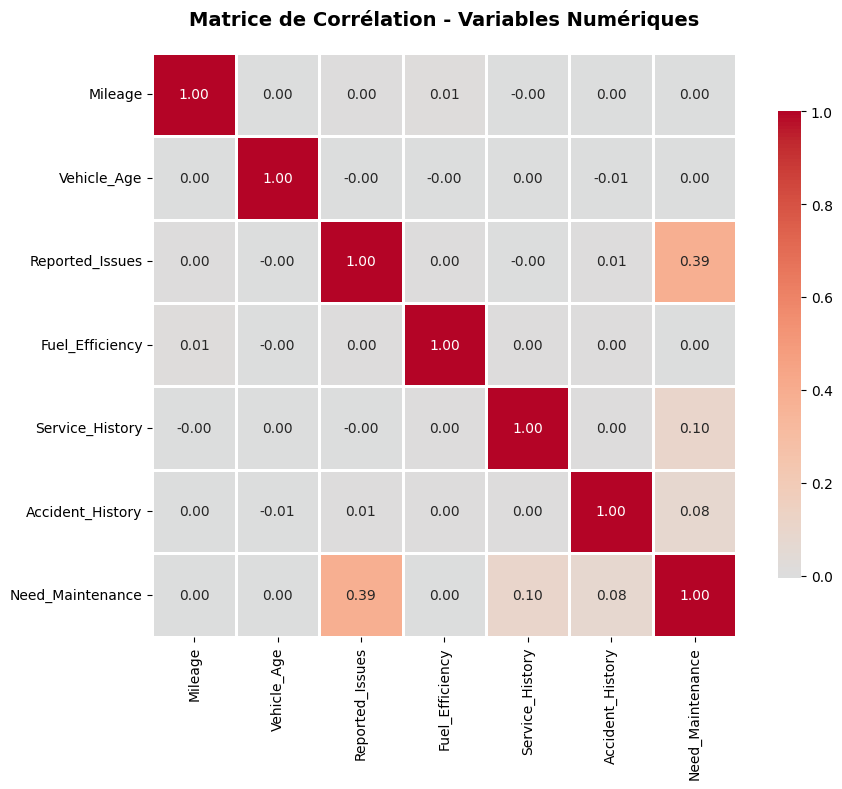


Corrélation avec Need_Maintenance :
Reported_Issues     0.389273
Service_History     0.104155
Accident_History    0.080590
Fuel_Efficiency     0.001874
Vehicle_Age         0.000806
Mileage             0.000704
Name: Need_Maintenance, dtype: float64


In [13]:
numerical_df = df[numerical_cols + ['Need_Maintenance']].copy()
corr_matrix = numerical_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation - Variables Numériques', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nCorrélation avec Need_Maintenance :")
corr_target = corr_matrix['Need_Maintenance'].drop('Need_Maintenance').sort_values(ascending=False)
print(corr_target)

# **Ces variables catégorielles contiennent toute l'information pour prédire**
Les 4 variables catégorielles contiennent 100% de l'information :
Maintenance_History (Bon/Moyen/Mauvais)
Tire_Condition (Neuf/Bon/Usé)
Brake_Condition (Neuf/Bon/Usé)
Battery_Status (Neuf/Bon/Faible)

In [14]:
# Créer X et y
features = numerical_cols + categorical_cols
print(f"\n Nombre total de features : {len(features)}")
print(f"   - Numériques : {len(numerical_cols)}")
print(f"   - Catégorielles : {len(categorical_cols)}")

X = df[features].copy()
y = df['Need_Maintenance'].copy()

print(f"\n X shape : {X.shape}")
print(f" y shape : {y.shape}")

# Vérifier les types
print(f"\n Types de données dans X :")
print(X.dtypes)


 Nombre total de features : 10
   - Numériques : 6
   - Catégorielles : 4

 X shape : (50000, 10)
 y shape : (50000,)

 Types de données dans X :
Mileage                  int64
Vehicle_Age              int64
Reported_Issues          int64
Fuel_Efficiency        float64
Service_History          int64
Accident_History         int64
Maintenance_History     object
Tire_Condition          object
Brake_Condition         object
Battery_Status          object
dtype: object


## Treating Data Leakage

We noticed in our dataset that there is some data leakage.

The initial model achieved 100% accuracy, which indicated potential data
leakage. Investigation revealed that Battery_Status and Brake_Condition are
perfect predictors because they represent post-inspection assessments - they're
determined AFTER the maintenance decision is made.

=>  deterministic rules

In [15]:
print("How many samples have Battery_Status = 2?")
battery_2_count = (X['Battery_Status'] == 2).sum()
print(f"Count: {battery_2_count} ({battery_2_count/len(X)*100:.1f}%)")

print("\nHow many samples have Brake_Condition = 2?")
brake_2_count = (X['Brake_Condition'] == 2).sum()
print(f"Count: {brake_2_count} ({brake_2_count/len(X)*100:.1f}%)")

print("\nHow many samples have EITHER Battery=2 OR Brake=2?")
either_count = ((X['Battery_Status'] == 2) | (df['Brake_Condition'] == 2)).sum()
print(f"Count: {either_count} ({either_count/len(df)*100:.1f}%)")

How many samples have Battery_Status = 2?
Count: 0 (0.0%)

How many samples have Brake_Condition = 2?
Count: 0 (0.0%)

How many samples have EITHER Battery=2 OR Brake=2?
Count: 0 (0.0%)


"If battery is weak OR brakes are worn → Car needs maintenance"

Battery_Status and Brake_Condition are "post-inspection" features - We only know them AFTER you've already decided the car needs maintenance!

So our model uses these features to "cheat" also known as "DATA LEAKAGE" which would result for 100% accuracy => Not realistic.

**Solution opted: Remove features that are only known AFTER inspection, the feature that makes our model cheat**

In [16]:
X.columns

Index(['Mileage', 'Vehicle_Age', 'Reported_Issues', 'Fuel_Efficiency',
       'Service_History', 'Accident_History', 'Maintenance_History',
       'Tire_Condition', 'Brake_Condition', 'Battery_Status'],
      dtype='object')

In [17]:
X = X.drop(['Battery_Status', 'Brake_Condition'], axis=1)

SO we only kept the features that we need for our model to predict if the the car needs maintenenace or not, which are the following:

In [18]:
X.columns

Index(['Mileage', 'Vehicle_Age', 'Reported_Issues', 'Fuel_Efficiency',
       'Service_History', 'Accident_History', 'Maintenance_History',
       'Tire_Condition'],
      dtype='object')

In [19]:
categorical_cols_not_leaked = ['Maintenance_History', 'Tire_Condition']

In [20]:
#5. PRÉPARATION DES DONNÉES
# ================================
print(f"\n Encodage des variables catégorielles : {categorical_cols_not_leaked}")
label_encoders = {}

for col in categorical_cols_not_leaked:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"    {col} : {len(le.classes_)} classes → {list(le.classes_)}")


 Encodage des variables catégorielles : ['Maintenance_History', 'Tire_Condition']
    Maintenance_History : 3 classes → ['Average', 'Good', 'Poor']
    Tire_Condition : 3 classes → ['Good', 'New', 'Worn Out']


In [21]:
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print(f"\n Imputation terminée. Valeurs manquantes restantes : {X_imputed.isnull().sum().sum()}")



 Imputation terminée. Valeurs manquantes restantes : 0


In [22]:
# Normalisation (CRUCIAL pour SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

**Splitting data**

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\n Train set : {X_train.shape}")
print(f" Test set  : {X_test.shape}")

train_dist = np.bincount(y_train)
test_dist = np.bincount(y_test)

print(f"\n Distribution y_train : {train_dist} → [{train_dist[0]/len(y_train)*100:.1f}%, {train_dist[1]/len(y_train)*100:.1f}%]")
print(f" Distribution y_test  : {test_dist} → [{test_dist[0]/len(y_test)*100:.1f}%, {test_dist[1]/len(y_test)*100:.1f}%]")


 Train set : (40000, 8)
 Test set  : (10000, 8)

 Distribution y_train : [ 7602 32398] → [19.0%, 81.0%]
 Distribution y_test  : [1900 8100] → [19.0%, 81.0%]


In [24]:
X_train

array([[-2.73871405e-01,  1.76565115e-01,  8.79337506e-01, ...,
        -1.34127879e+00,  3.92188152e-03, -1.69417881e-03],
       [ 1.47209468e+00, -5.18929095e-01, -8.76317779e-01, ...,
         4.45234956e-01,  3.92188152e-03, -1.22935998e+00],
       [-8.57966321e-01, -1.71181990e-01,  1.46455593e+00, ...,
        -1.34127879e+00,  3.92188152e-03, -1.69417881e-03],
       ...,
       [-1.18952281e+00,  8.72059325e-01,  8.79337506e-01, ...,
         4.45234956e-01,  3.92188152e-03,  1.22597163e+00],
       [ 1.44064021e+00,  1.76565115e-01, -8.76317779e-01, ...,
        -1.34127879e+00,  1.22950986e+00, -1.69417881e-03],
       [-1.70216817e+00, -1.21442330e+00,  1.46455593e+00, ...,
        -1.34127879e+00,  3.92188152e-03, -1.22935998e+00]])

# XGBOOST

In [25]:
from xgboost import XGBClassifier

In [26]:
y_train.value_counts()

,count
Need_Maintenance,
1,32398
0,7602


since our target value isnt balanced we're going to play around with

```
scale_pos_weight
```



In [37]:
count_0 = (y_train == 0).sum()
count_1 = (y_train == 1).sum()
scale_weight = count_0 / count_1

In [38]:
scale_weight

np.float64(0.2346441138341873)

In [40]:
params = {
            'objective':'binary:logistic',
            'max_depth': 6,
            'alpha': 10,
            'learning_rate': 0.1,
            'n_estimators':100,
            'scale_pos_weight': scale_weight,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'eval_metric': 'logloss',
            'random_state': 42,
            'n_jobs': -1
}

Explanation of XGBoost Hyperparameters

objective: 'binary:logistic'
Trains a binary classification model that outputs probabilities between 0 and 1.

max_depth: 6
Sets the maximum depth of each decision tree. Higher values make the model more complex and prone to overfitting.

alpha: 10
L1 regularization term. Helps reduce overfitting by pushing less important weights toward zero.

learning_rate: 0.1
Controls how fast the model learns. Lower values make learning slower but more stable.

n_estimators: 100
Number of boosting rounds, meaning how many trees will be built.

scale_pos_weight: scale_weight
Adjusts the balance between positive and negative classes. Useful for imbalanced datasets.

subsample: 0.8
Fraction of the training data used for each tree. Adds randomness and reduces overfitting.

colsample_bytree: 0.8
Fraction of features used for each tree. Also helps prevent overfitting.

eval_metric: 'logloss'
Evaluation metric used during training. Logarithmic loss is appropriate for binary classification.

random_state: 42
Ensures reproducible training results.

n_jobs: -1
Uses all available CPU cores to speed up training.

In [42]:
# instantiate the classifier
xgboost = XGBClassifier(**params)

# fit the classifier to the training data
xgboost.fit(X_train, y_train)


score = roc_auc_score(y_test, xgboost.predict_proba(X_test)[:, 1])
print(f"AUC: {score:.4f}")

AUC: 0.8548


In [46]:
# make predictions on test data
y_pred_xgb = xgboost.predict(X_test)

In [64]:
y_proba_xgb = xgboost.predict_proba(X_test)[:, 1]

In [47]:
accuracy = accuracy_score(y_test, y_pred_xgb)


print('accuracy: ', accuracy)

accuracy:  0.7588


In [48]:
auc = roc_auc_score(y_test, y_pred_xgb)
print('auc: ',auc)

auc:  0.8511111111111112


1. matrice de confusion

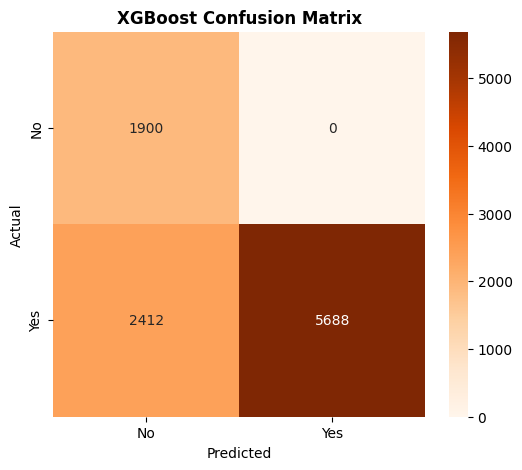


Interpretation:
- The model correctly predicts 75.9% of cases
- AUC of 0.8511 indicates good class separation


In [49]:
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('XGBoost Confusion Matrix', fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nInterpretation:")
print(f"- The model correctly predicts {accuracy*100:.1f}% of cases")
print(f"- AUC of {auc:.4f} indicates {'excellent' if auc > 0.9 else 'good' if auc > 0.8 else 'fair'} class separation")

In [63]:
len(y_train)

40000

Total samples = 1900 + 0 + 2412 + 5688 = 10,000

It is extremely conservative about predicting "Yes". It only predicts "Yes" when it is very, very confident (that’s why FP = 0 → perfect precision).
But because it’s so cautious, it misses a lot of the actual "Yes" cases (2,412 false negatives), so recall is only ~70%.

2. ROC CURVE

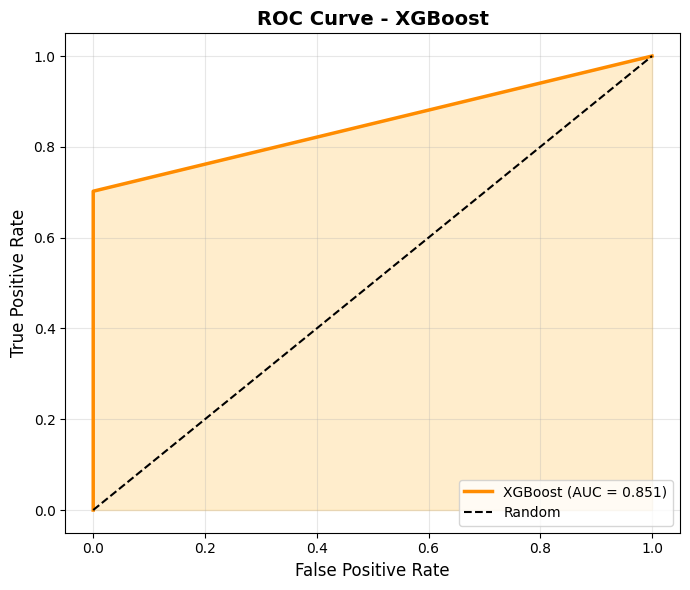

In [51]:
fpr, tpr, _ = roc_curve(y_test, y_pred_xgb)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, linewidth=2.5, color='darkorange',
         label=f'XGBoost (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random')
plt.fill_between(fpr, tpr, alpha=0.2, color='orange')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - XGBoost', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

It shows how well your model separates the two classes ("needs maintenance" vs "doesn't") across all possible classification thresholds.

4. TRAIN VS TEST (Overfitting Check)

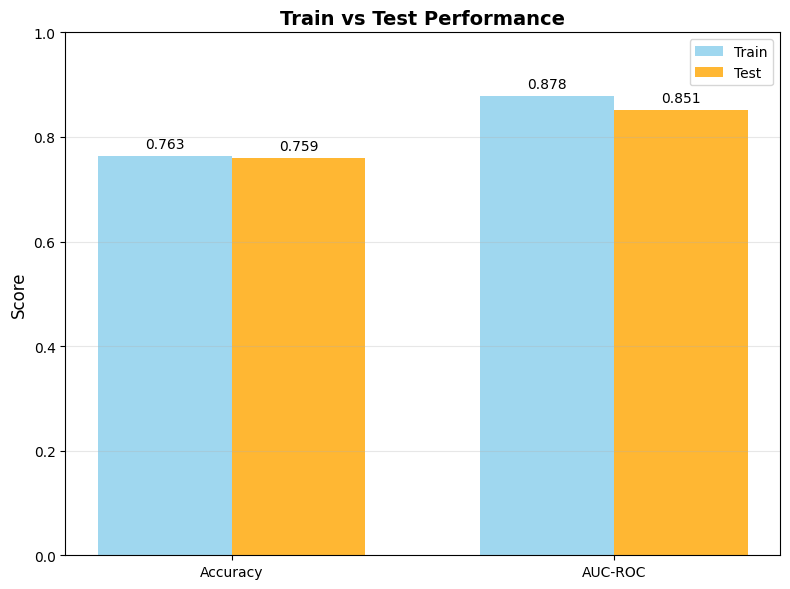

In [52]:
y_train_pred = xgboost.predict(X_train)
y_train_proba = xgboost.predict_proba(X_train)[:, 1]

train_acc = accuracy_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_proba)

# Bar chart comparison
fig, ax = plt.subplots(figsize=(8, 6))
metrics = ['Accuracy', 'AUC-ROC']
train_scores = [train_acc, train_auc]
test_scores = [accuracy, auc]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, train_scores, width, label='Train',
               color='skyblue', alpha=0.8)
bars2 = ax.bar(x + width/2, test_scores, width, label='Test',
               color='orange', alpha=0.8)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Train vs Test Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Add values on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

Train vs Test Performance – Simple Interpretation

Accuracy: Train = 76.3%, Test = 75.9% → almost identical, no overfitting on accuracy.
AUC-ROC: Train = 87.8%, Test = 85.1% → only a tiny drop of 2.7%.

Conclusion: The model generalizes very well to unseen data. There is no significant overfitting, so the performance you see on the test set (AUC ≈ 0.85) is trustworthy and can be reported with confidence.

In [53]:
gap = train_acc - accuracy

In [54]:
gap

0.004049999999999998

No significant overfitting


In [56]:
print(classification_report(y_test, y_pred_xgb,
                          target_names=['No Maintenance', 'Yes Maintenance']))


                 precision    recall  f1-score   support

 No Maintenance       0.44      1.00      0.61      1900
Yes Maintenance       1.00      0.70      0.83      8100

       accuracy                           0.76     10000
      macro avg       0.72      0.85      0.72     10000
   weighted avg       0.89      0.76      0.78     10000



# Random Forest

In [27]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)


In [28]:
# Grille très petite pour RandomizedSearch
param_dist = {
    'n_estimators': [10, 30, 50],       # très petit pour la recherche
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'class_weight': ['balanced']
}




In [29]:
# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=8,
    scoring='roc_auc',
    cv=2,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("\nMeilleurs paramètres trouvés :")
for param, value in random_search.best_params_.items():
    print(f"  - {param}: {value}")

print(f"\nMeilleur score AUC (CV) : {random_search.best_score_:.4f}")

Fitting 2 folds for each of 8 candidates, totalling 16 fits

Meilleurs paramètres trouvés :
  - n_estimators: 10
  - min_samples_split: 5
  - min_samples_leaf: 5
  - max_features: sqrt
  - max_depth: 15
  - class_weight: balanced
  - bootstrap: True

Meilleur score AUC (CV) : 0.8560


**to use the best model**

In [30]:
best_model = random_search.best_estimator_


In [31]:
best_model

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=5, min_samples_split=5, n_estimators=10,
                       n_jobs=-1, random_state=42)

In [32]:
y_pred_rf = best_model.predict(X_test)
y_proba_rf = best_model.predict_proba(X_test)[:, 1]


In [33]:
# Métriques
acc_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

print(f"\n PERFORMANCES RANDOM FOREST")
print(f"   Accuracy : {acc_rf:.4f} ({acc_rf*100:.2f}%)")
print(f"   AUC-ROC  : {auc_rf:.4f}")

print("\n Rapport de classification :")
print(classification_report(y_test, y_pred_rf, target_names=['Non (0)', 'Oui (1)']))


 PERFORMANCES RANDOM FOREST
   Accuracy : 0.7614 (76.14%)
   AUC-ROC  : 0.8551

 Rapport de classification :
              precision    recall  f1-score   support

     Non (0)       0.44      0.96      0.60      1900
     Oui (1)       0.99      0.71      0.83      8100

    accuracy                           0.76     10000
   macro avg       0.71      0.84      0.72     10000
weighted avg       0.88      0.76      0.79     10000



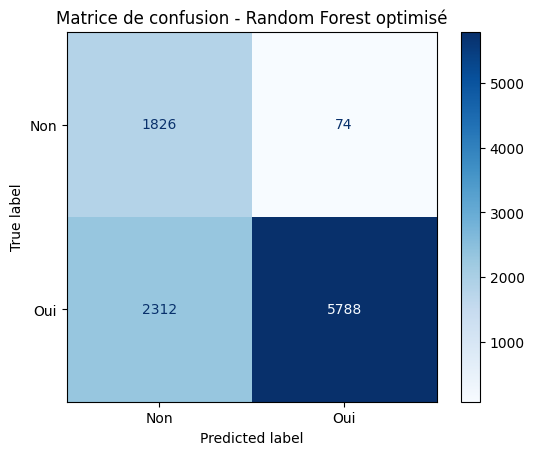

In [34]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non', 'Oui'])
disp.plot(cmap="Blues")
plt.title("Matrice de confusion - Random Forest optimisé")
plt.show()


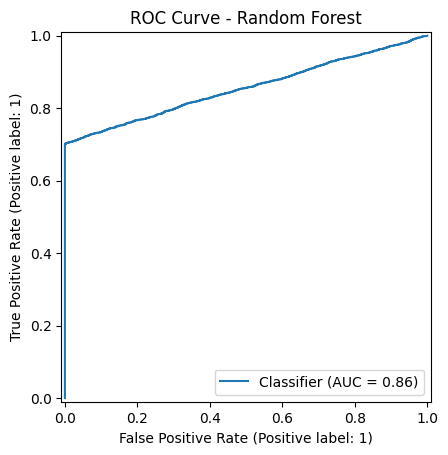

In [35]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.title("ROC Curve - Random Forest")
plt.show()

In [318]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

print("\n Validation croisée (AUC ROC) :")
print(f"  Moyenne : {cv_scores.mean():.4f}")
print(f"  Écart-type : {cv_scores.std():.4f}")



 Validation croisée (AUC ROC) :
  Moyenne : 0.8539
  Écart-type : 0.0031


# SVM

In [57]:

#SVM
svm_model = SVC(
    kernel='rbf',
    C=10.0,
    gamma='scale',
    probability=True,
    class_weight='balanced',
    random_state=42,
    verbose=False
)

svm_model.fit(X_train, y_train)



SVC(C=10.0, class_weight='balanced', probability=True, random_state=42)

In [58]:
# Prédictions
y_pred_svm = svm_model.predict(X_test)
y_proba_svm = svm_model.predict_proba(X_test)[:, 1]

In [59]:
# Métriques
acc_svm = accuracy_score(y_test, y_pred_svm)
auc_svm = roc_auc_score(y_test, y_proba_svm)

print(f"\n PERFORMANCES SVM")
print(f"   Accuracy : {acc_svm:.4f} ({acc_svm*100:.2f}%)")
print(f"   AUC-ROC  : {auc_svm:.4f}")

print("\n Rapport de classification :")
print(classification_report(y_test, y_pred_svm, target_names=['Non (0)', 'Oui (1)']))

print(f"\n Nombre de vecteurs de support : {svm_model.n_support_.sum()}")
print(f"   Classe 0 (Non) : {svm_model.n_support_[0]}")
print(f"   Classe 1 (Oui) : {svm_model.n_support_[1]}")


 PERFORMANCES SVM
   Accuracy : 0.7550 (75.50%)
   AUC-ROC  : 0.8543

 Rapport de classification :
              precision    recall  f1-score   support

     Non (0)       0.44      1.00      0.61      1900
     Oui (1)       1.00      0.70      0.82      8100

    accuracy                           0.76     10000
   macro avg       0.72      0.85      0.71     10000
weighted avg       0.89      0.76      0.78     10000


 Nombre de vecteurs de support : 15719
   Classe 0 (Non) : 3529
   Classe 1 (Oui) : 12190


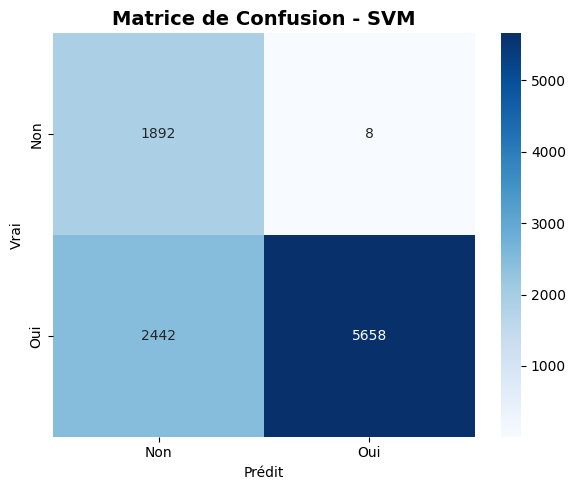

In [60]:
# Matrice de confusion
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
plt.title('Matrice de Confusion - SVM', fontsize=14, fontweight='bold')
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.tight_layout()
plt.show()

# Comparaison: SVM vs Random Forest vs XGBOOST

In [61]:
print("\n" + "="*60)
print(" COMPARAISON RF vs SVM")
print("="*60)

print(f"\nRandom Forest → Accuracy: {acc_rf:.4f} ({acc_rf*100:.2f}%) | AUC: {auc_rf:.4f}")
print(f"SVM           → Accuracy: {acc_svm:.4f} ({acc_svm*100:.2f}%) | AUC: {auc_svm:.4f}")

diff = abs(acc_rf - acc_svm)
if diff < 0.001:
    meilleur = "Égalité (performances identiques)"
elif acc_rf > acc_svm:
    meilleur = f"Random Forest (meilleur de {diff*100:.2f}%)"
else:
    meilleur = f"SVM (meilleur de {diff*100:.2f}%)"

print(f"\n Résultat : {meilleur}")



 COMPARAISON RF vs SVM

Random Forest → Accuracy: 0.7614 (76.14%) | AUC: 0.8551
SVM           → Accuracy: 0.7550 (75.50%) | AUC: 0.8543

 Résultat : Random Forest (meilleur de 0.64%)



COURBES ROC


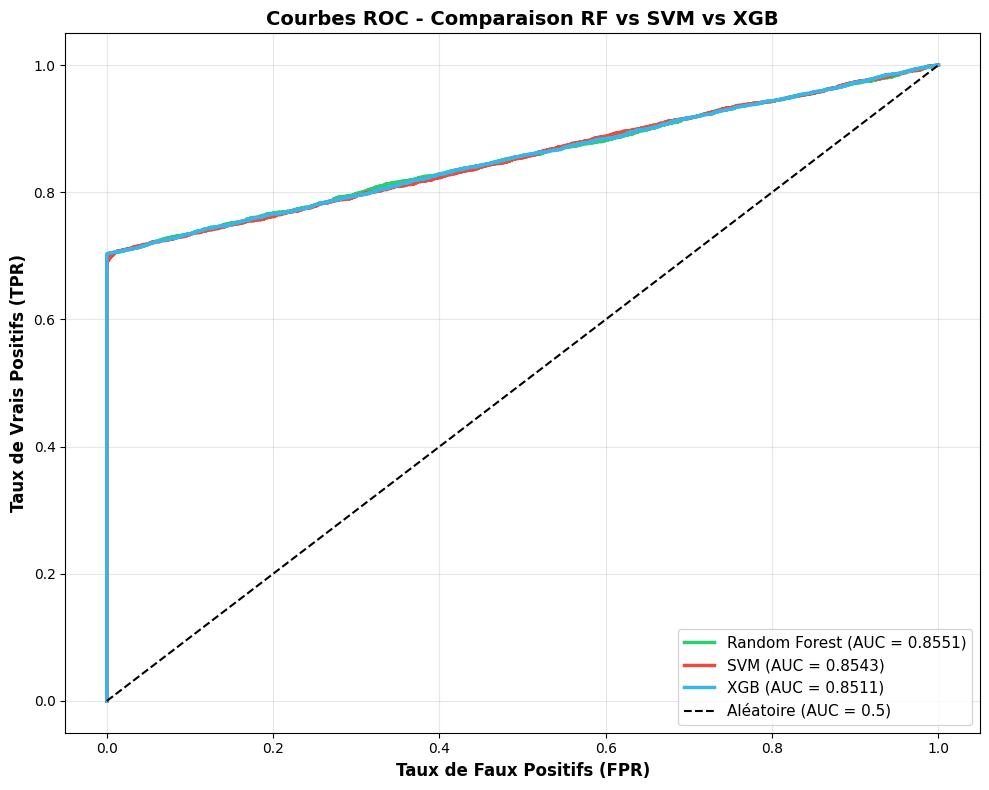

In [67]:
# ================================
# 14. COURBES ROC
# ================================
print("\n" + "="*60)
print("COURBES ROC")
print("="*60)

plt.figure(figsize=(10, 8))

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})',
         color='#2ecc71', linewidth=2.5)

# SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.4f})',
         color='#e74c3c', linewidth=2.5)

#XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGB (AUC = {auc:.4f})',
         color='#3cb4e7', linewidth=2.5)

# Diagonale
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire (AUC = 0.5)', linewidth=1.5)

plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12, fontweight='bold')
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12, fontweight='bold')
plt.title('Courbes ROC - Comparaison RF vs SVM vs XGB', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Random Forest achieves the highest AUC (0.855), very closely followed by SVM (0.854) and XGBoost (0.851). All three models demonstrate excellent and nearly identical discriminative power, with Random Forest being the top performer on this imbalanced vehicle maintenance dataset.

In [68]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score

In [69]:
def get_all_metrics(y_true, y_pred, y_proba):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'AUC-ROC': roc_auc_score(y_true, y_proba),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    }

# Calculate for all models
metrics_rf = get_all_metrics(y_test, y_pred_rf, y_proba_rf)
metrics_svm = get_all_metrics(y_test, y_pred_svm, y_proba_svm)
metrics_xgb = get_all_metrics(y_test, y_pred_xgb, y_proba_xgb)

# Create comparison DataFrame
comparison = pd.DataFrame({
    'Random Forest': metrics_rf,
    'SVM': metrics_svm,
    'XGBoost': metrics_xgb
}).T

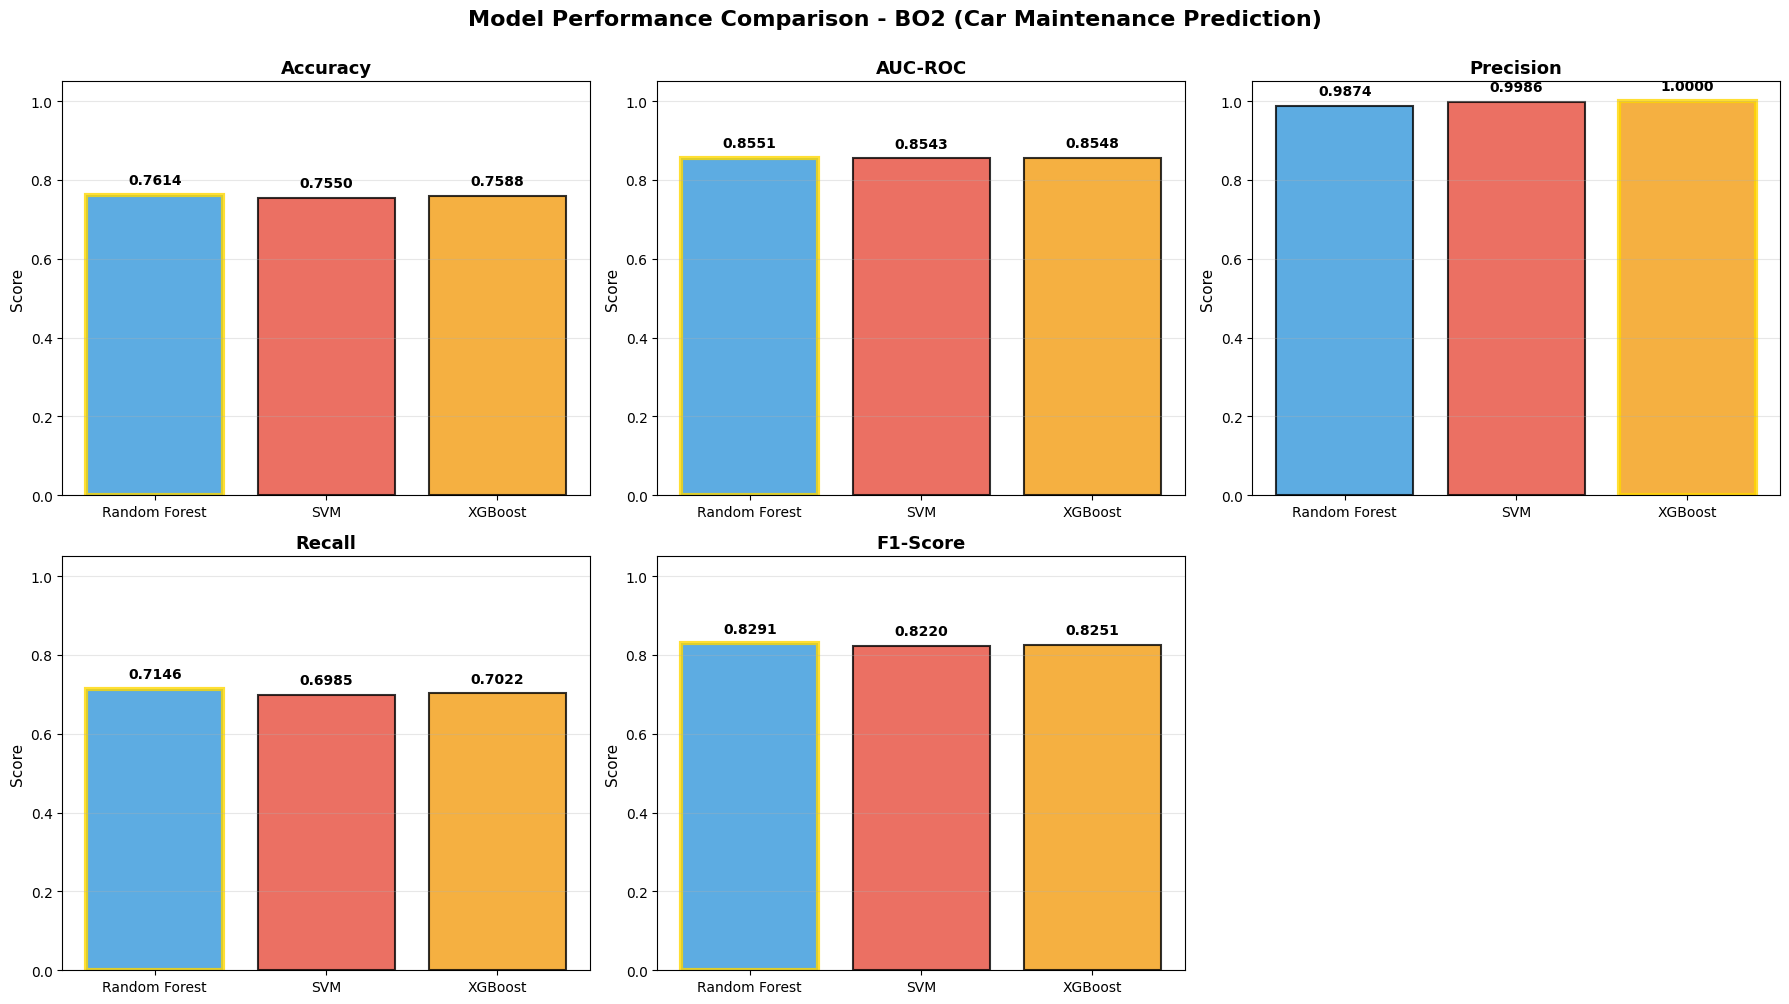

In [70]:

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison - BO2 (Car Maintenance Prediction)',
             fontsize=16, fontweight='bold', y=1.00)

metrics_list = ['Accuracy', 'AUC-ROC', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#f39c12']  # Blue, Red, Orange

for idx, metric in enumerate(metrics_list):
    ax = axes[idx // 3, idx % 3]

    models = ['Random Forest', 'SVM', 'XGBoost']
    scores = [metrics_rf[metric], metrics_svm[metric], metrics_xgb[metric]]

    bars = ax.bar(models, scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

    winner_idx = scores.index(max(scores))
    bars[winner_idx].set_edgecolor('gold')
    bars[winner_idx].set_linewidth(3)

    ax.set_ylabel('Score', fontsize=11)
    ax.set_title(metric, fontsize=13, fontweight='bold')
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3)

    for i, (bar, score) in enumerate(zip(bars, scores)):
        height = bar.get_height()
        label = f'{score:.4f}'
        if i == winner_idx:
            label = f'{label}'
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                label, ha='center', va='bottom', fontsize=10, fontweight='bold')

axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

Random forest wins, but also XGBoost has more precision